# <p style='text-align: center;'> Fuzzy gain scheduling of PID controllers</p>

### Importing needed libraries

In [1]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
import control.matlab as mt

### Plant transfer function

In [2]:
num = [27]
den = [1,1]
sys1 = mt.tf(num,den)

num = [1]
den = [1,3]
sys2 = mt.tf(num,den)

sys = sys1*pow(sys2,4)
sys


                     27
--------------------------------------------
s^5 + 13 s^4 + 66 s^3 + 162 s^2 + 189 s + 81

### Step response

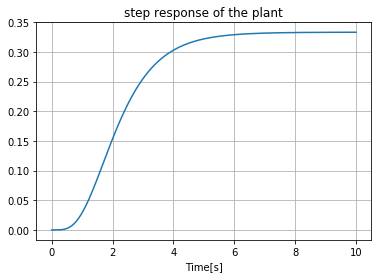

In [3]:
T = np.linspace(0,10,10000)
sim = mt.step(sys,T=T)
plt.plot(sim[1],sim[0])
plt.grid(True)
plt.title("step response of the plant")
plt.xlabel("Time[s]");

### Determination of $K_u$ , $T_u$ , $\dot{e}_{max}$ and $e_{max}$

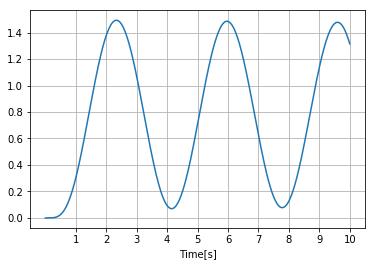

In [4]:
T = np.linspace(0,10,10000)
ku=10.6
# ku=5.1
clsys = ku*sys/(1+ku*sys)
sim = mt.step(clsys,T=T)

plt.plot(sim[1], sim[0])
plt.grid(True)
plt.xticks(np.linspace(1,10,10));
plt.xlabel("Time[s]");

$\rightarrow K_u = 10.6 \hspace{1cm} T_u = 3.7 $

In [5]:
Ku=10.6
Tu=3.7
# Ku=5.1
# Tu=2.8
kpmin=0.32*Ku
kpmax=0.6*Ku
kdmin=0.08*Ku*Tu
kdmax=0.15*Ku*Tu
print(kpmin,kpmax,kdmin,kdmax)

3.392 6.359999999999999 3.1376 5.883


In [6]:
np.diff(sim[0]).max()/(10/10000)

1.2307967320753788

$\rightarrow  \dot{e}_{max} = 2 \hspace{1cm}  e_{max}=1$

In [7]:
demax=2
emax=1

# Data Base

### Fuzzy sets for $\dot{e}$ and $e$ 

In [8]:
class triangularFuzzySet:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c

A = [triangularFuzzySet(-4/3+i/3, -1+i/3, -2/3+i/3) for i in range(7)]
B = A

Visualization of $\dot{e}$ and $e$ 

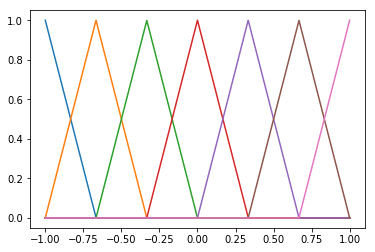

In [9]:
x = np.linspace(-1,1,2001)
for i in range(7):
    plt.plot(x,fuzz.membership.trimf(x, [A[i].a, A[i].b, A[i].c]), label='A'+str(i))  

### Fuzzy sets for $k'_p$ and $k'_d$

In [10]:
class logarithmicFuzzySet:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c

C = [logarithmicFuzzySet(-1/4, 0, 1), logarithmicFuzzySet(-1/4, 1, -1) ]

# Rules Base

In [11]:
NB = 0
NM = 1
NS = 2
ZO = 3
PS = 4
PM = 5
PB = 6
S=0
B=1

Fuzzy tuning rules for $k'_p$

In [12]:
                #         de(K)
                #NB NM NS ZO PS PM PB
rule_base_kp = [[B, B, B, B, B, B, B], #NB 
                [S, B, B, B, B, B, S], #NM 
                [S, S, B, B, B, S, S], #NS 
                [S, S, S, B, S, S, S], #ZO   e(K)
                [S, S, B, B, B, S, S], #PS 
                [S, B, B, B, B, B, S], #PM 
                [B, B, B, B, B, B, B]] #PB 

Fuzzy tuning rules for $k'_d$

In [13]:
                #         de(K)
                #NB NM NS ZO PS PM PB
rule_base_kd = [[S, S, S, S, S, S, S], #NB 
                [B, B, S, S, S, B, B], #NM 
                [B, B, B, S, B, B, B], #NS 
                [B, B, B, B, B, B, B], #ZO   e(K)
                [B, B, B, S, B, B, B], #PS 
                [B, B, S, S, S, B, B], #PM 
                [S, S, S, S, S, S, S]] #PB 

Fuzzy tuning rules for $\alpha$

In [14]:
              #         de(K)
              #NB NM NS ZO PS PM PB
rule_base_alpha = [[2, 2, 2, 2, 2, 2, 2], #NB 
                   [3, 3, 2, 2, 2, 3, 3], #NM 
                   [4, 3, 3, 2, 3, 3, 4], #NS 
                   [5, 4, 3, 3, 3, 4, 5], #ZO   e(K)
                   [4, 3, 3, 2, 3, 3, 4], #PS 
                   [3, 3, 2, 2, 2, 3, 3], #PM 
                   [2, 2, 2, 2, 2, 2, 2]] #PB 

# Inference Mechanism

## Degrees of compatibility 

In [15]:
#Degrees of compatibility : MIN of MAX-MIN Inference
def doc(fuzzy_set, singleton_input):
    if (singleton_input<=fuzzy_set.a):
        return 0
    
    if (singleton_input>fuzzy_set.a and singleton_input<=fuzzy_set.b):
        return (1/(fuzzy_set.b-fuzzy_set.a)*(singleton_input-fuzzy_set.a))
    
    if (singleton_input>fuzzy_set.b and singleton_input<=fuzzy_set.c):
        return (1-1/(fuzzy_set.c-fuzzy_set.b)*(singleton_input-fuzzy_set.b))
    
    if (singleton_input>fuzzy_set.c):
        return 0

## Inference of $k'_{pi}$ and $k'_{di}$

In [16]:
def inference_for_logarithmic_set(fuzzy_set, value):
    return ( (np.exp(value/fuzzy_set.a)-fuzzy_set.b)/fuzzy_set.c )

## Defuzzification

Deifned in "Fuzzy Gain Scheduling Module"

# Fuzzy Gain Scheduling Module

In [17]:
def fuzzy_gain_scheduling(e, de):
    
    # Implication of u
    u = np.array([[doc(A[i], e)*doc(A[j], de) for j in range(7)] for i in range(7)])
    
    # Inference of kpi and kdi
    kpi   = np.array([[doc(C[rule_base_kp[i][j]],u[i][j]) for j in range(7)] for i in range(7)])
    kdi   = np.array([[doc(C[rule_base_kd[i][j]],u[i][j]) for j in range(7)] for i in range(7)])
    
    #Defuzzification
    kp = np.sum(np.multiply(kpi,u))
    kd = np.sum(np.multiply(kdi,u))
    alpha = np.sum(np.multiply(rule_base_alpha,u))
    
    return kp, kd, alpha

# Simulation

Converting transfer function of plant to state space model

In [18]:
ss=mt.tf2ss(sys)

#### Fuzzy PID

Simulation loop over 10 secconds with 0.001 second stem time

In [19]:
dt=0.001
Tf=14
time = np.linspace(0,Tf,int(Tf/dt))

kp_mem =np.zeros((1,0))
kd_mem =np.zeros((1,0))
ki_mem =np.zeros((1,0))
r_mem = np.zeros((1,0))
y_mem = np.zeros((1,0))
x = np.zeros((5,1))
r = 1
error = 0
error_previous = 0
d_error = 0
y=0
i=0
for t in time:
    error = r - y
    d_error = error - error_previous
    error_previous = error
    i += error
    
    kpn, kdn, alpha = fuzzy_gain_scheduling(error/emax, d_error/demax)
    
    kp = kpmin+(kpmax-kpmin)*kpn
    kd = kdmin+(kdmax-kdmin)*kdn
    ki = kp*kp/(alpha*kd)

    u = kp*error + ki*dt*i + kd/dt*d_error
    
    xd = ss.A*x + ss.B*u
    x = x + xd*dt
    y = ss.C*x 
    y_mem = np.append(y_mem,y)
    r_mem = np.append(r_mem,r)
    kp_mem = np.append(kp_mem,kp)
    kd_mem = np.append(kd_mem,kd)
    ki_mem = np.append(ki_mem,ki)

#### PID

In [20]:
time2 = np.linspace(0,Tf,int(Tf/dt))

r_mem2 = np.zeros((1,0))
y_mem2 = np.zeros((1,0))
x = np.zeros((5,1))
r = 1
error = 0
error_previous = 0
d_error = 0
y=0
i=0
for t in time2:
    error = r - y
    d_error = error - error_previous
    error_previous = error
    i += error
    
    kp = 8
    kd = 1
    ki = 1

    u = kp*error + ki*dt*i + kd/dt*d_error
    
    xd = ss.A*x + ss.B*u
    x = x + xd*dt
    y = ss.C*x 
    y_mem2 = np.append(y_mem2,y)
    r_mem2 = np.append(r_mem2,r)

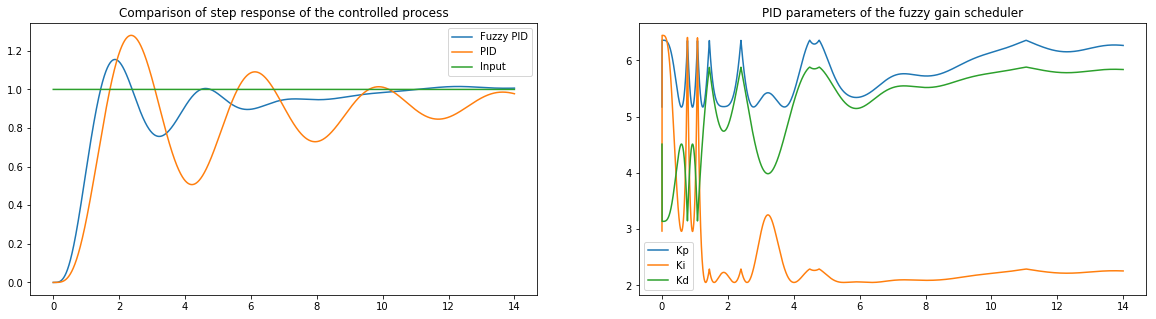

In [21]:
plt.figure(figsize=(20, 5))

plt.subplot(121)
plt.title("Comparison of step response of the controlled process")
plt.plot(time,y_mem, label='Fuzzy PID')
plt.plot(time,y_mem2, label='PID')
plt.plot(time,r_mem, label='Input')
plt.legend()

plt.subplot(122)
plt.title("PID parameters of the fuzzy gain scheduler")
plt.plot(time,kp_mem, label='Kp')
plt.plot(time,ki_mem, label='Ki')
plt.plot(time,kd_mem, label='Kd')
plt.legend()
